In [1]:
import numpy as np
%matplotlib inline

Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s


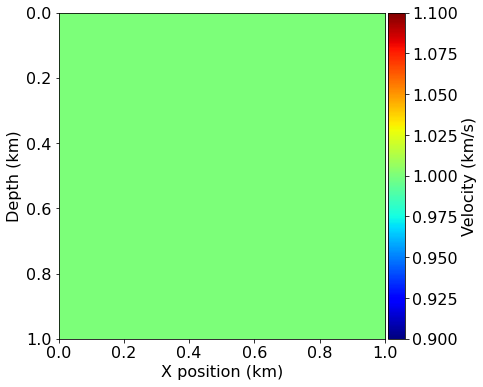

Grid[extent=(1200.0, 1200.0), shape=(121, 121), dimensions=(x, y)]


In [2]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import *

# Define a physical size
shape = (101, 101)  # Number of grid point (nx, nz)
spacing = (10., 10.)  # Grid spacing in m. The domain size is now 1km by 1km
origin = (0., 0.)  # What is the location of the top left corner. This is necessary to define
# the absolute location of the source and receivers

# Define a velocity profile. The velocity is in km/s
v = np.empty(shape, dtype=np.float32)
v[:,:] = 1

# With the velocity and model size defined, we can create the seismic model that
# encapsulates this properties. We also define the size of the absorbing layer as 10 grid points
model = Model(vp=v, origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbl=10, bcs="damp")

plot_velocity(model)
print(model.grid)

In [3]:
from examples.seismic import TimeAxis

t0 = 0.  # Simulation starts a t=0
tn = 1000.  # Simulation last 1 second (1000 ms)
dt = model.critical_dt  # Time step from model grid spacing
time_range = TimeAxis(start=t0, stop=tn, step=dt)

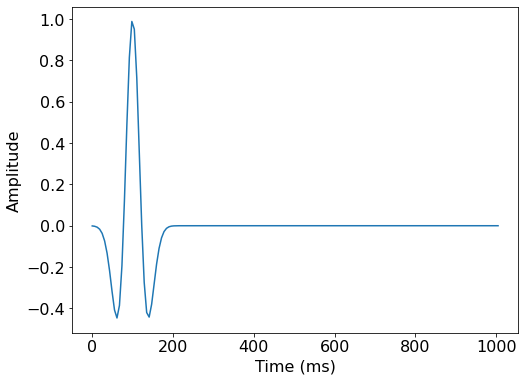

In [4]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import RickerSource

f0 = 0.010  # Source peak frequency is 10Hz (0.010 kHz)
src = RickerSource(name='src', grid=model.grid, f0=f0,
                   npoint=1, time_range=time_range)

# Set source coordinates
src.coordinates.data[0, 0] =model.domain_size[0] * .5
src.coordinates.data[0, 1] =model.domain_size[1] * .5

# We can plot the time signature to see the wavelet via:
src.show()

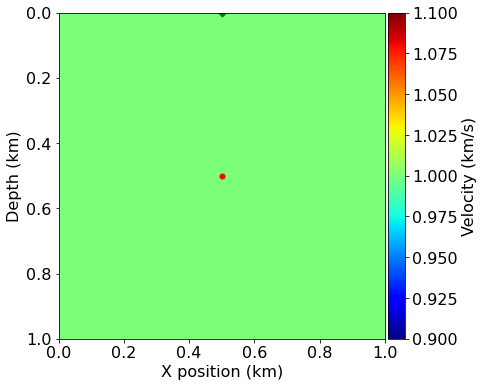

In [5]:
#NBVAL_IGNORE_OUTPUT

from examples.seismic import Receiver
from numpy import *
# Create symbol for 101 receivers
rec = Receiver(name='rec', grid=model.grid, npoint=1, time_range=time_range)

# Prescribe even spacing for receivers along the x-axis
R=200
b=1
   rec.coordinates.data[0]=[model.domain_size[0]*0.5,0]#model.domain_size[1]*0.5]

#uncomment this for circular distribution
#for a in range(0, 51):
 #   x=a*2*R/50-R
  #  xcoord=model.domain_size[0]/2 +x
   # rec.coordinates.data[a,0]=xcoord
    #y=sqrt(R**2-b*(x**2))
    #rec.coordinates.data[a,1]=model.domain_size[1]/2-y

#for a1 in range(51,101):
 #   x=(a1-51)*2*R/50-R
  #  xcoord=model.domain_size[0]/2 +x
 #rec.coordinates.data[a,0]=xcoord
   ##y=sqrt(R**2-b*(x**2))
  #  rec.coordinates.data[a1,1]=model.domain_size[1]/2+y    

plot_velocity(model, source=src.coordinates.data,
              receiver=rec.coordinates.data[::1,:])

In [6]:
# In order to represent the wavefield u and the square slowness we need symbolic objects 
# corresponding to time-space-varying field (u, TimeFunction) and 
# space-varying field (m, Function)
from devito import TimeFunction

# Define the wavefield with the size of the model and the time dimension
u = TimeFunction(name="u", grid=model.grid, time_order=2, space_order=2)

# We can now write the PDE
pde = model.m * u.dt2 - u.laplace + model.damp * u.dt

# The PDE representation is as on paper
pde


damp(x, y)*Derivative(u(t, x, y), t) - Derivative(u(t, x, y), (x, 2)) - Derivative(u(t, x, y), (y, 2)) + Derivative(u(t, x, y), (t, 2))/vp(x, y)**2

In [7]:
# This discrete PDE can be solved in a time-marching way updating u(t+dt) from the previous time step
# Devito as a shortcut for u(t+dt) which is u.forward. We can then rewrite the PDE as 
# a time marching updating equation known as a stencil using customized SymPy functions
from devito import Eq, solve

stencil = Eq(u.forward, solve(pde, u.forward))

In [8]:
# Finally we define the source injection and receiver read function to generate the corresponding code
src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m)

# Create interpolation expression for receivers
rec_term = rec.interpolate(expr=u.forward)


In [9]:
#NBVAL_IGNORE_OUTPUT
from devito import Operator

op = Operator([stencil] + src_term + rec_term, subs=model.spacing_map)


Now we can execute the create operator for a number of timesteps. We specify the number of timesteps to compute with the keyword `time` and the timestep size with `dt`.

In [10]:
#NBVAL_IGNORE_OUTPUT
op(time=time_range.num-1, dt=model.critical_dt)

Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.0012789999999999985, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=4e-06, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=8e-06, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

After running our operator kernel, the data associated with the receiver symbol `rec.data` has now been populated due to the interpolation expression we inserted into the operator. This allows us the visualize the shot record:

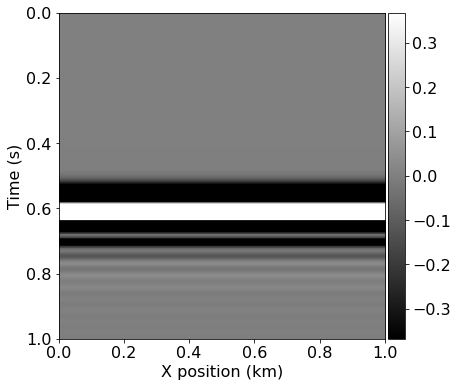

In [11]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import plot_shotrecord

plot_shotrecord(rec.data, model, t0, tn)